In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [72]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output dataframe.csv

'gdown' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [3]:
df = pd.read_csv('dataframe.csv', parse_dates=['Date'], index_col='Date')
#df = pd.read_csv('dataframe.csv')
#df['Date'] = pd.to_datetime(df['Date'])
#df.set_index('Date', inplace=True)
#df = df.sort_values(by='Date')
#df.head()
#df.plot(figsize=(15, 6))


In [4]:
df.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2010-12-20,3377,67979.0,68196.0,67264.0,67264.0,67264.0,2352800.0
1998-05-18,159,10906.0,10908.0,10010.0,10205.0,10205.0,0.0
2011-06-13,3495,62701.0,62968.0,62022.0,62023.0,62023.0,1397200.0
2000-10-09,784,15946.0,15975.0,15617.0,15855.0,15855.0,0.0
2006-02-27,2178,NaN,NaN,NaN,NaN,NaN,NaN


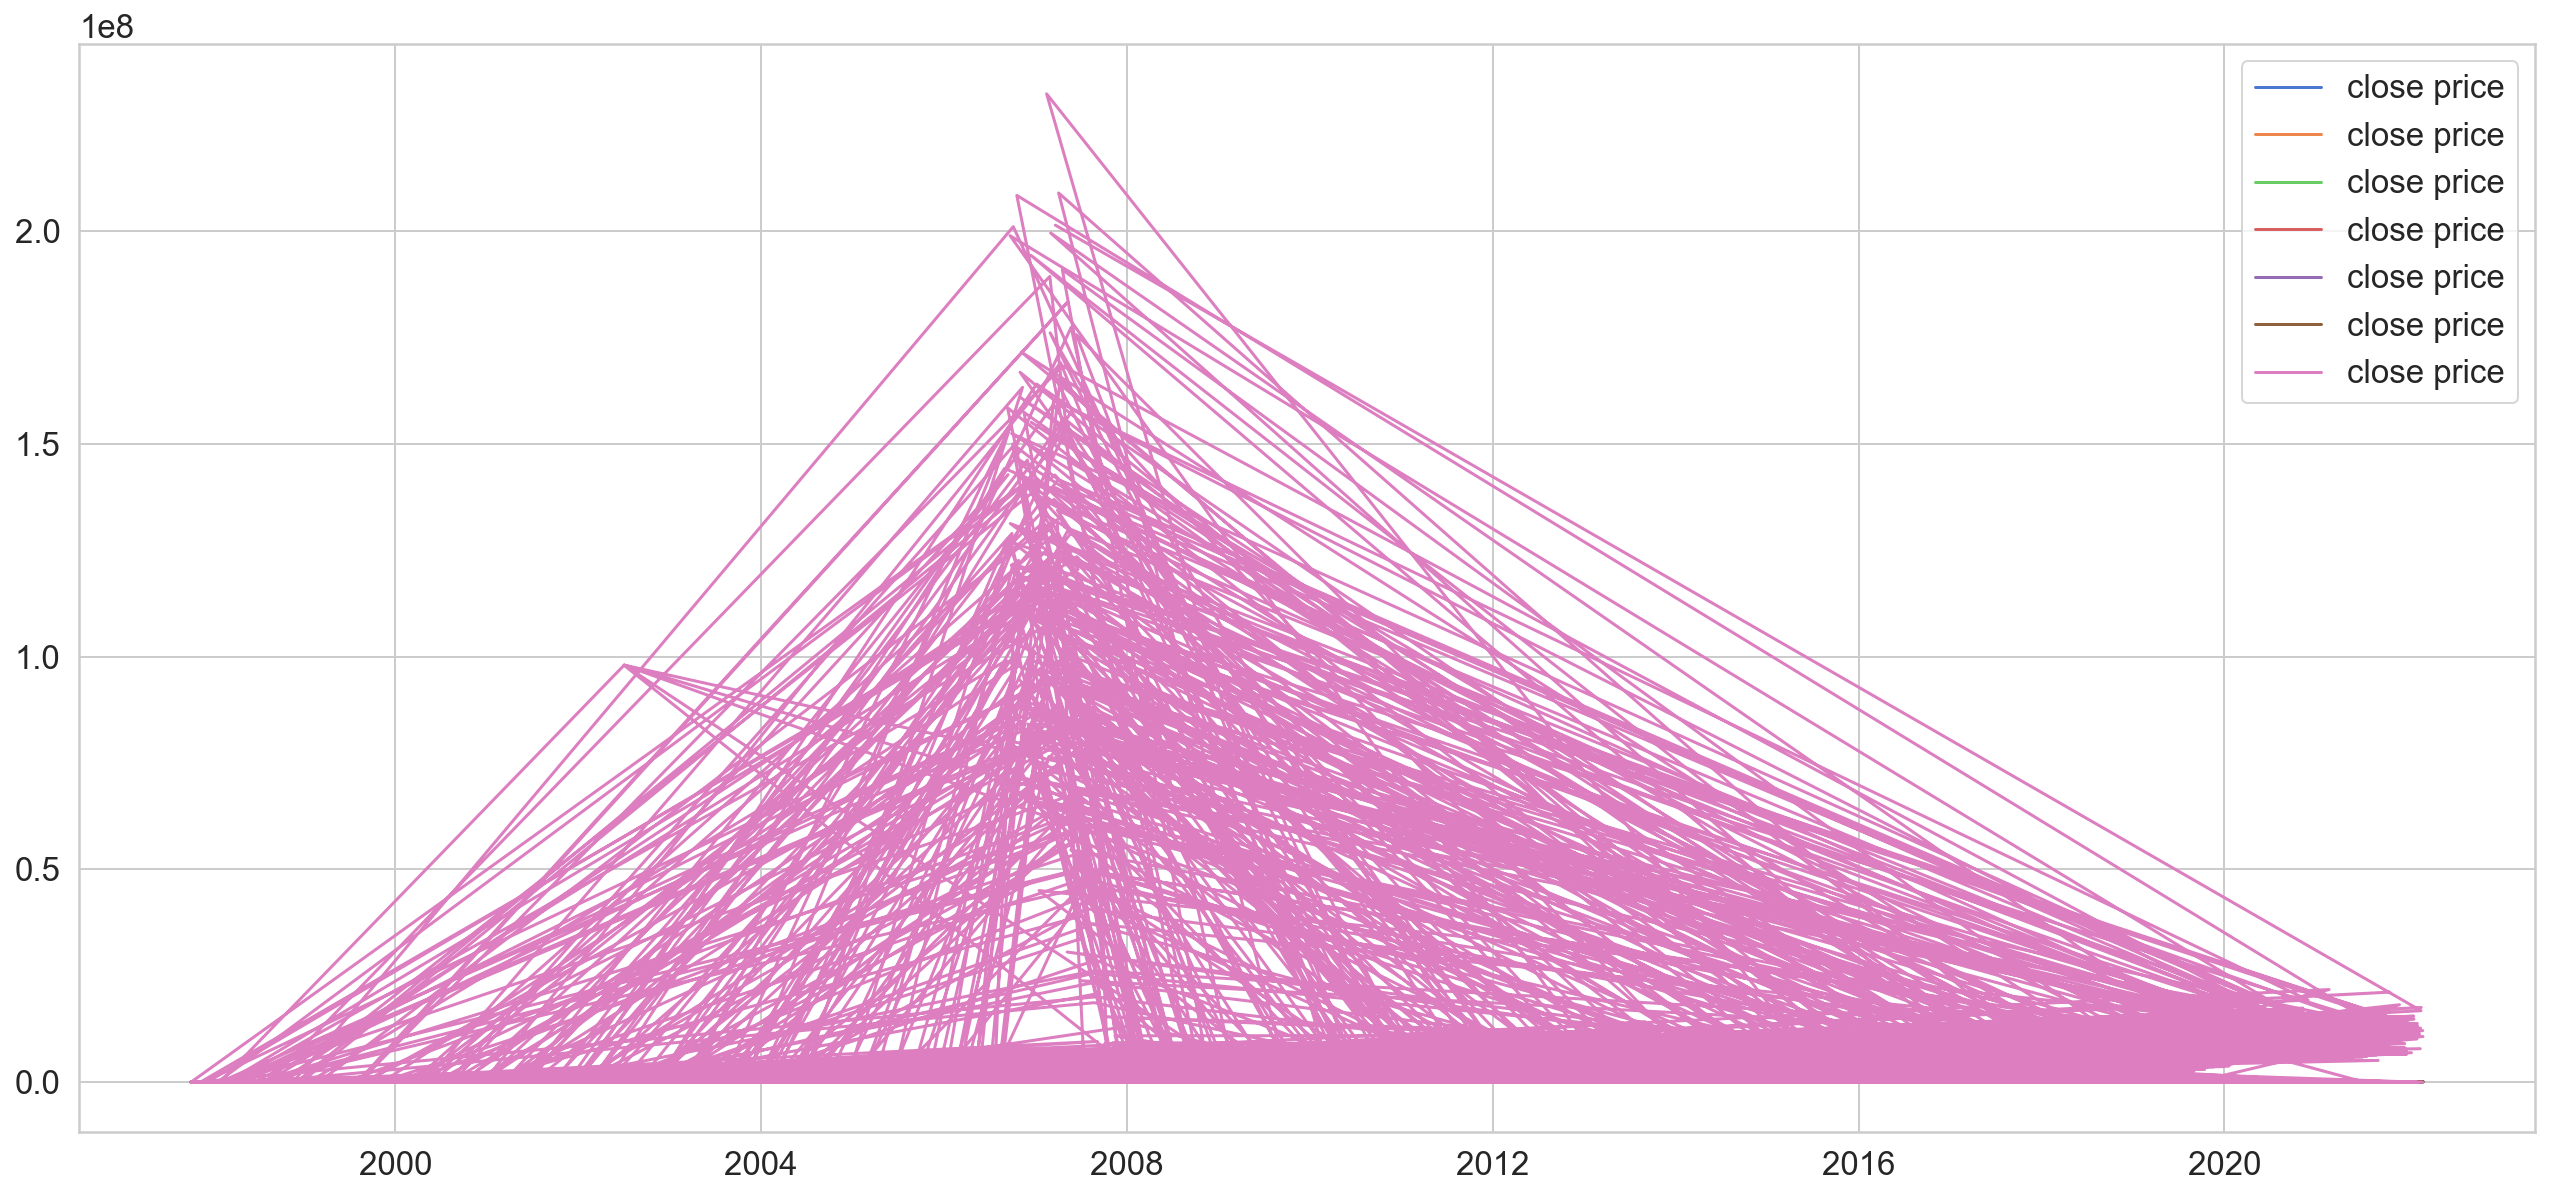

In [5]:
plt.plot(df, label='close price')
plt.legend()

### Introduce an Anomaly

In [6]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(5848, 7) (308, 7)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

C:\Users\Lucas Silva\AppData\Local\Temp\ipykernel_6620\1564450779.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = scaler.transform(train[['Close']])
C:\Users\Lucas Silva\AppData\Local\Temp\ipykernel_6620\1564450779.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = scaler.transform(test[['Close']])


In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [9]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['Close']], train.Close, TIME_STEPS)
X_test, y_test = create_dataset(test[['Close']], test.Close, TIME_STEPS)

print(X_train.shape)

(5818, 30, 1)


In [10]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            65        
 ibuted)                                                

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
164/164 [==============================] - 8s 30ms/step - loss: nan - val_loss: nan
Epoch 2/10
164/164 [==============================] - 4s 25ms/step - loss: nan - val_loss: nan
Epoch 3/10
164/164 [==============================] - 4s 24ms/step - loss: nan - val_loss: nan
Epoch 4/10
164/164 [==============================] - 4s 27ms/step - loss: nan - val_loss: nan
Epoch 5/10
164/164 [==============================] - 4s 26ms/step - loss: nan - val_loss: nan
Epoch 6/10
164/164 [==============================] - 5s 29ms/step - loss: nan - val_loss: nan
Epoch 7/10
164/164 [==============================] - 4s 22ms/step - loss: nan - val_loss: nan
Epoch 8/10
164/164 [==============================] - 4s 24ms/step - loss: nan - val_loss: nan
Epoch 9/10
164/164 [==============================] - 4s 27ms/step - loss: nan - val_loss: nan
Epoch 10/10
164/164 [==============================] - 4s 24ms/step - loss: nan - val_loss: nan


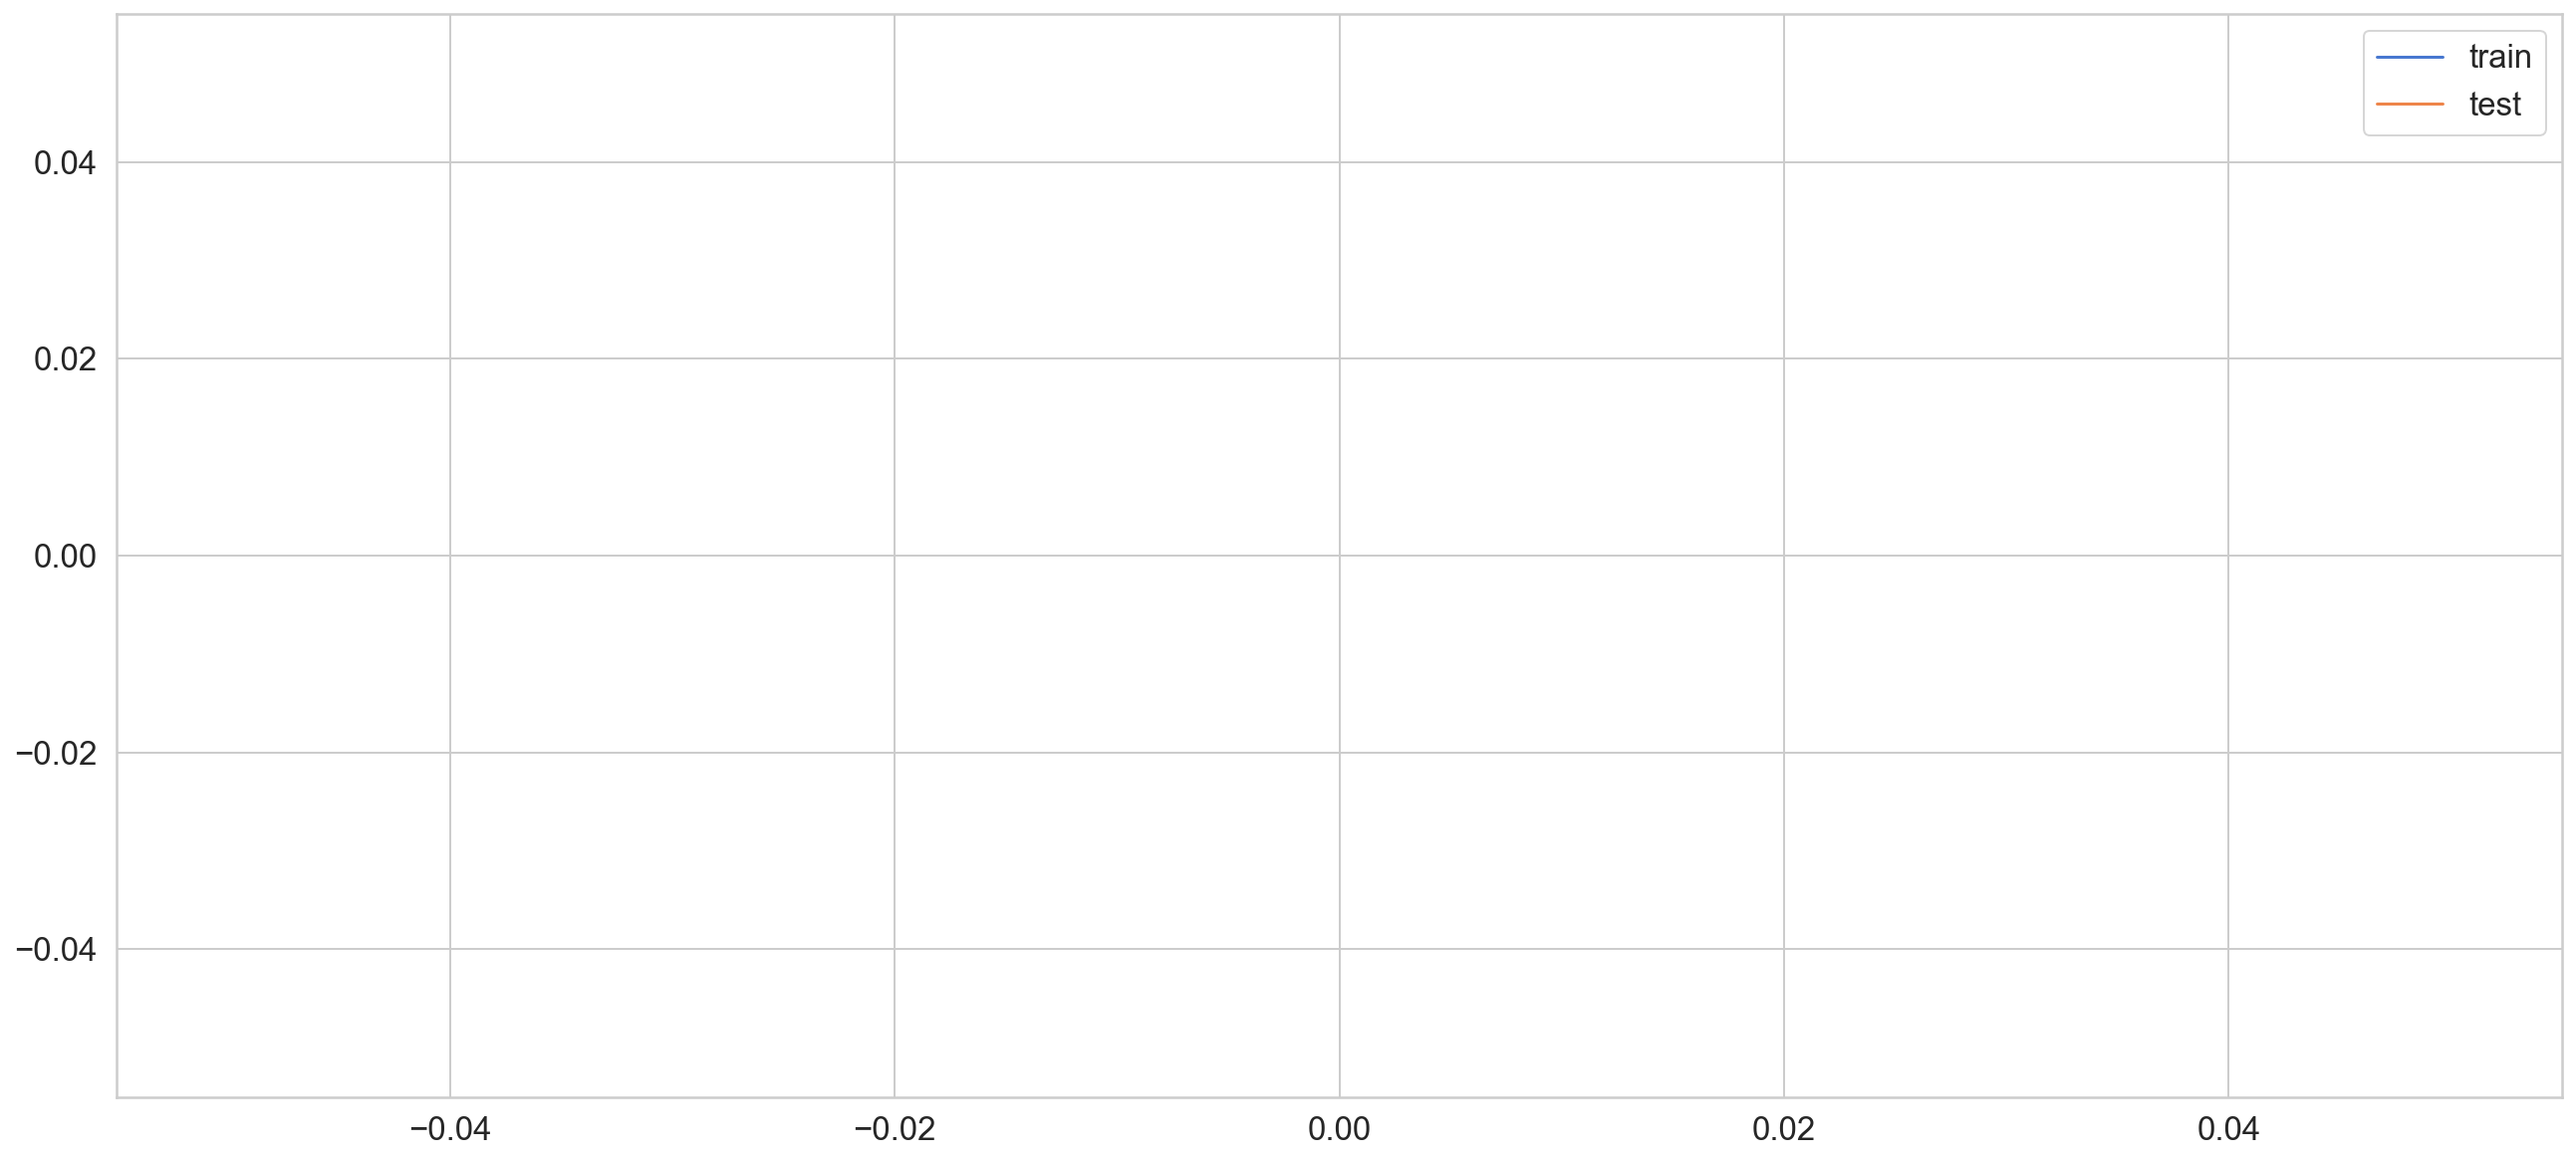

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [13]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

d:\Lucas Programacao\10 Seletivo - Anomalia\Aprendizado-de-maquina-Anomalias-Seletivo-\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\Lucas Programacao\10 Seletivo - Anomalia\Aprendizado-de-maquina-Anomalias-Seletivo-\venv\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
d:\Lucas Programacao\10 Seletivo - Anomalia\Aprendizado-de-maquina-Anomalias-Seletivo-\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Lucas Programacao\10 Seletivo - Anomalia\Aprendizado-de-maquina-Anomalias-Seletivo-\venv\lib\site-packages\numpy\lib\histograms.py:

<AxesSubplot:>

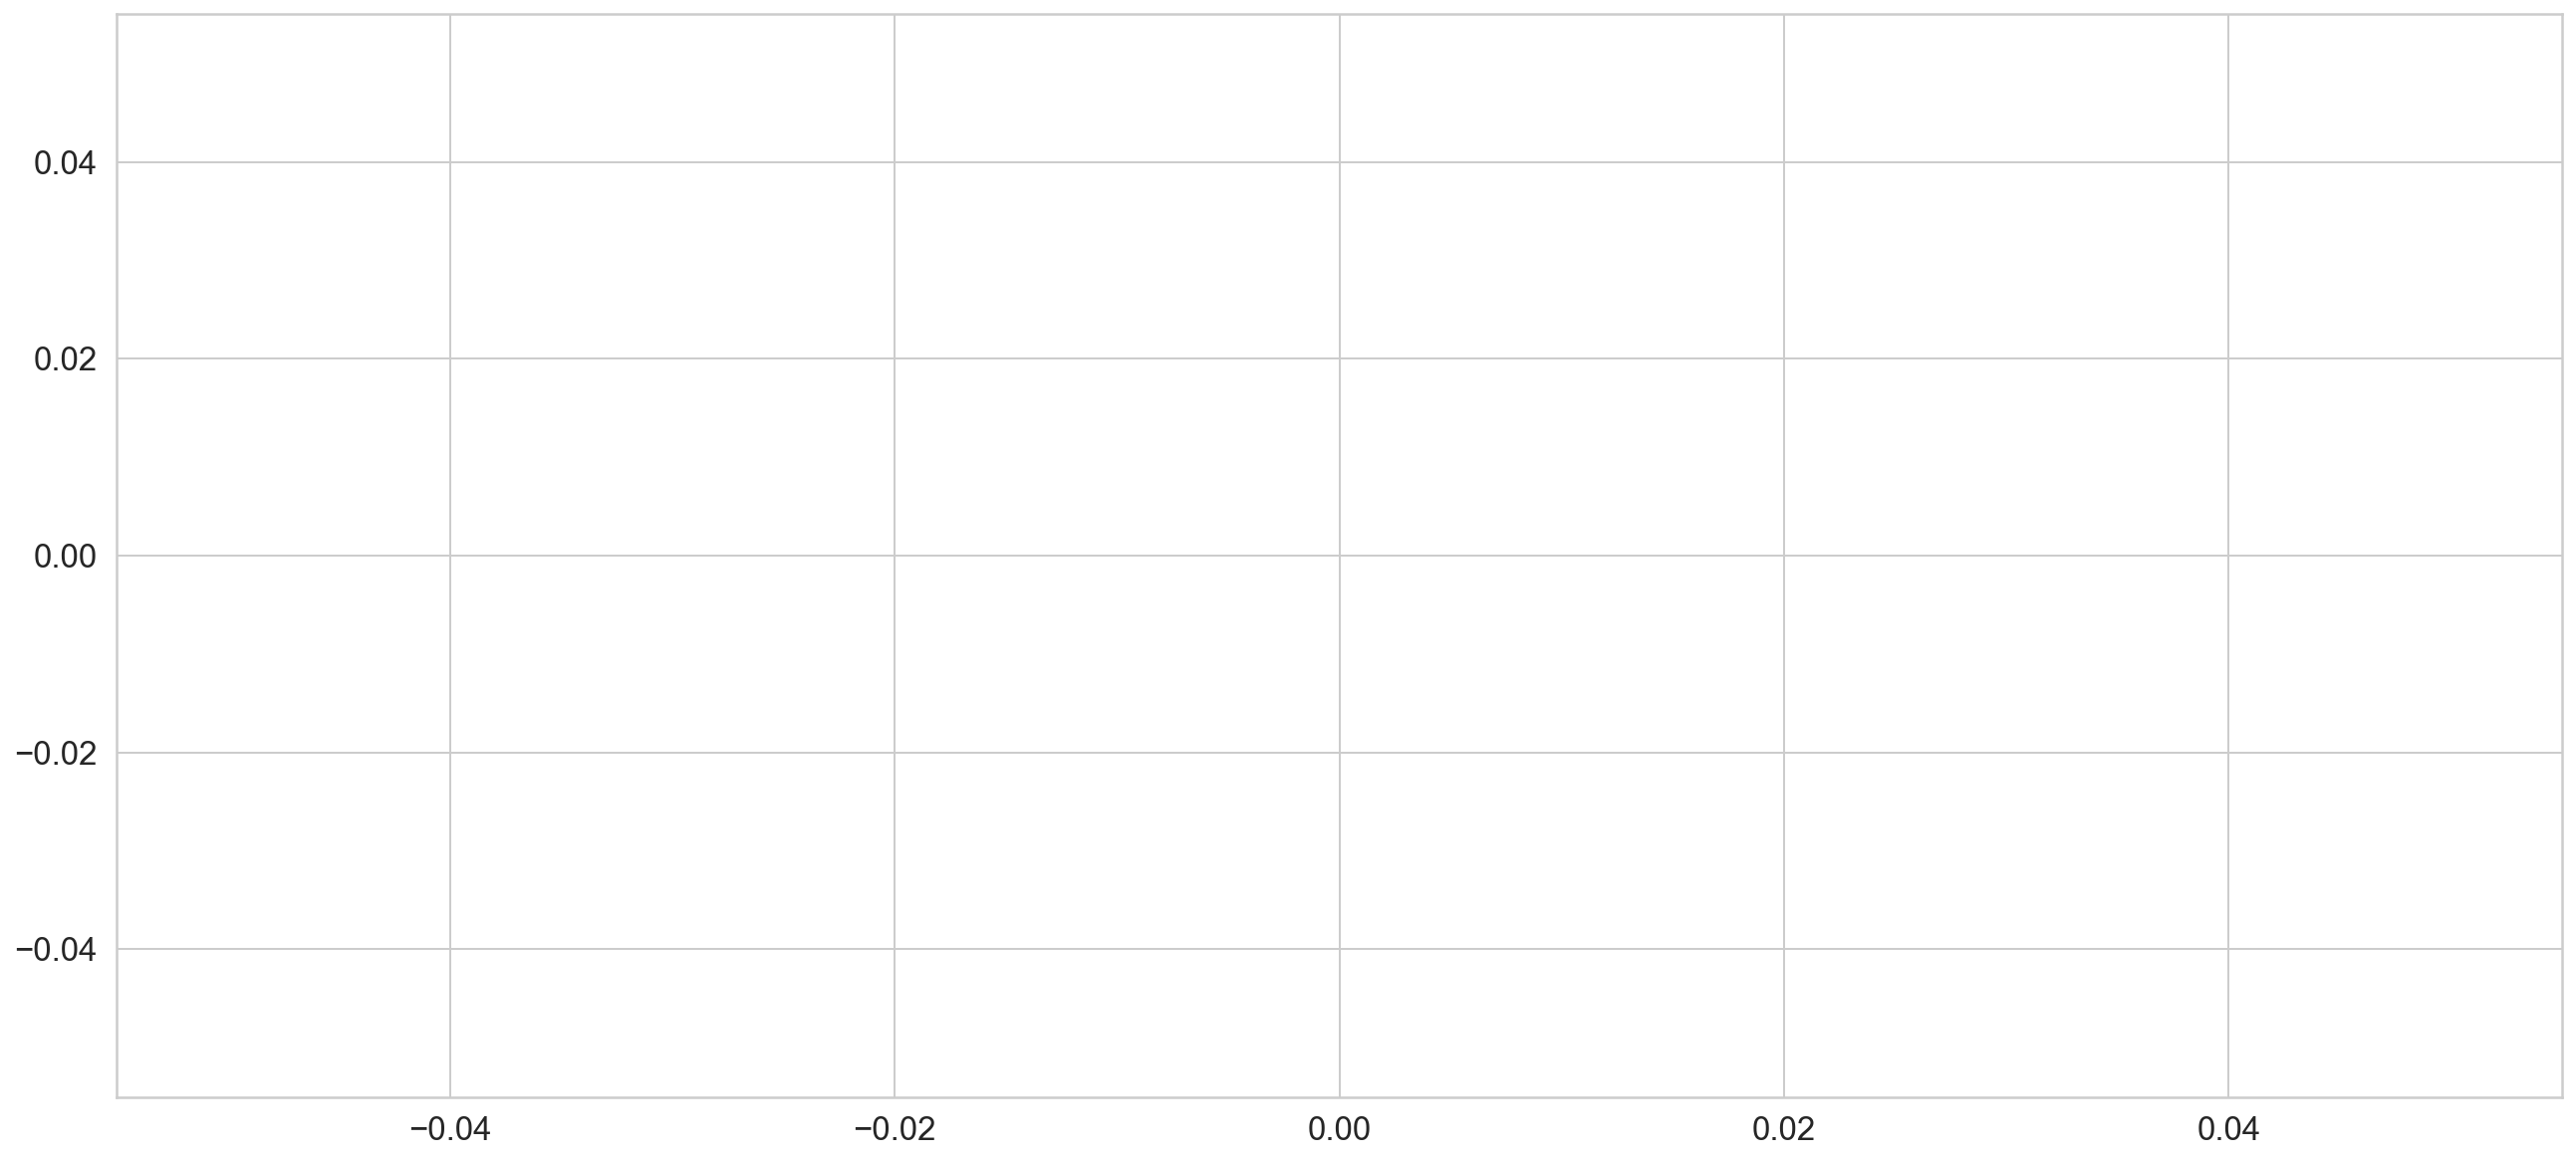

In [14]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [15]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [19]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].Close

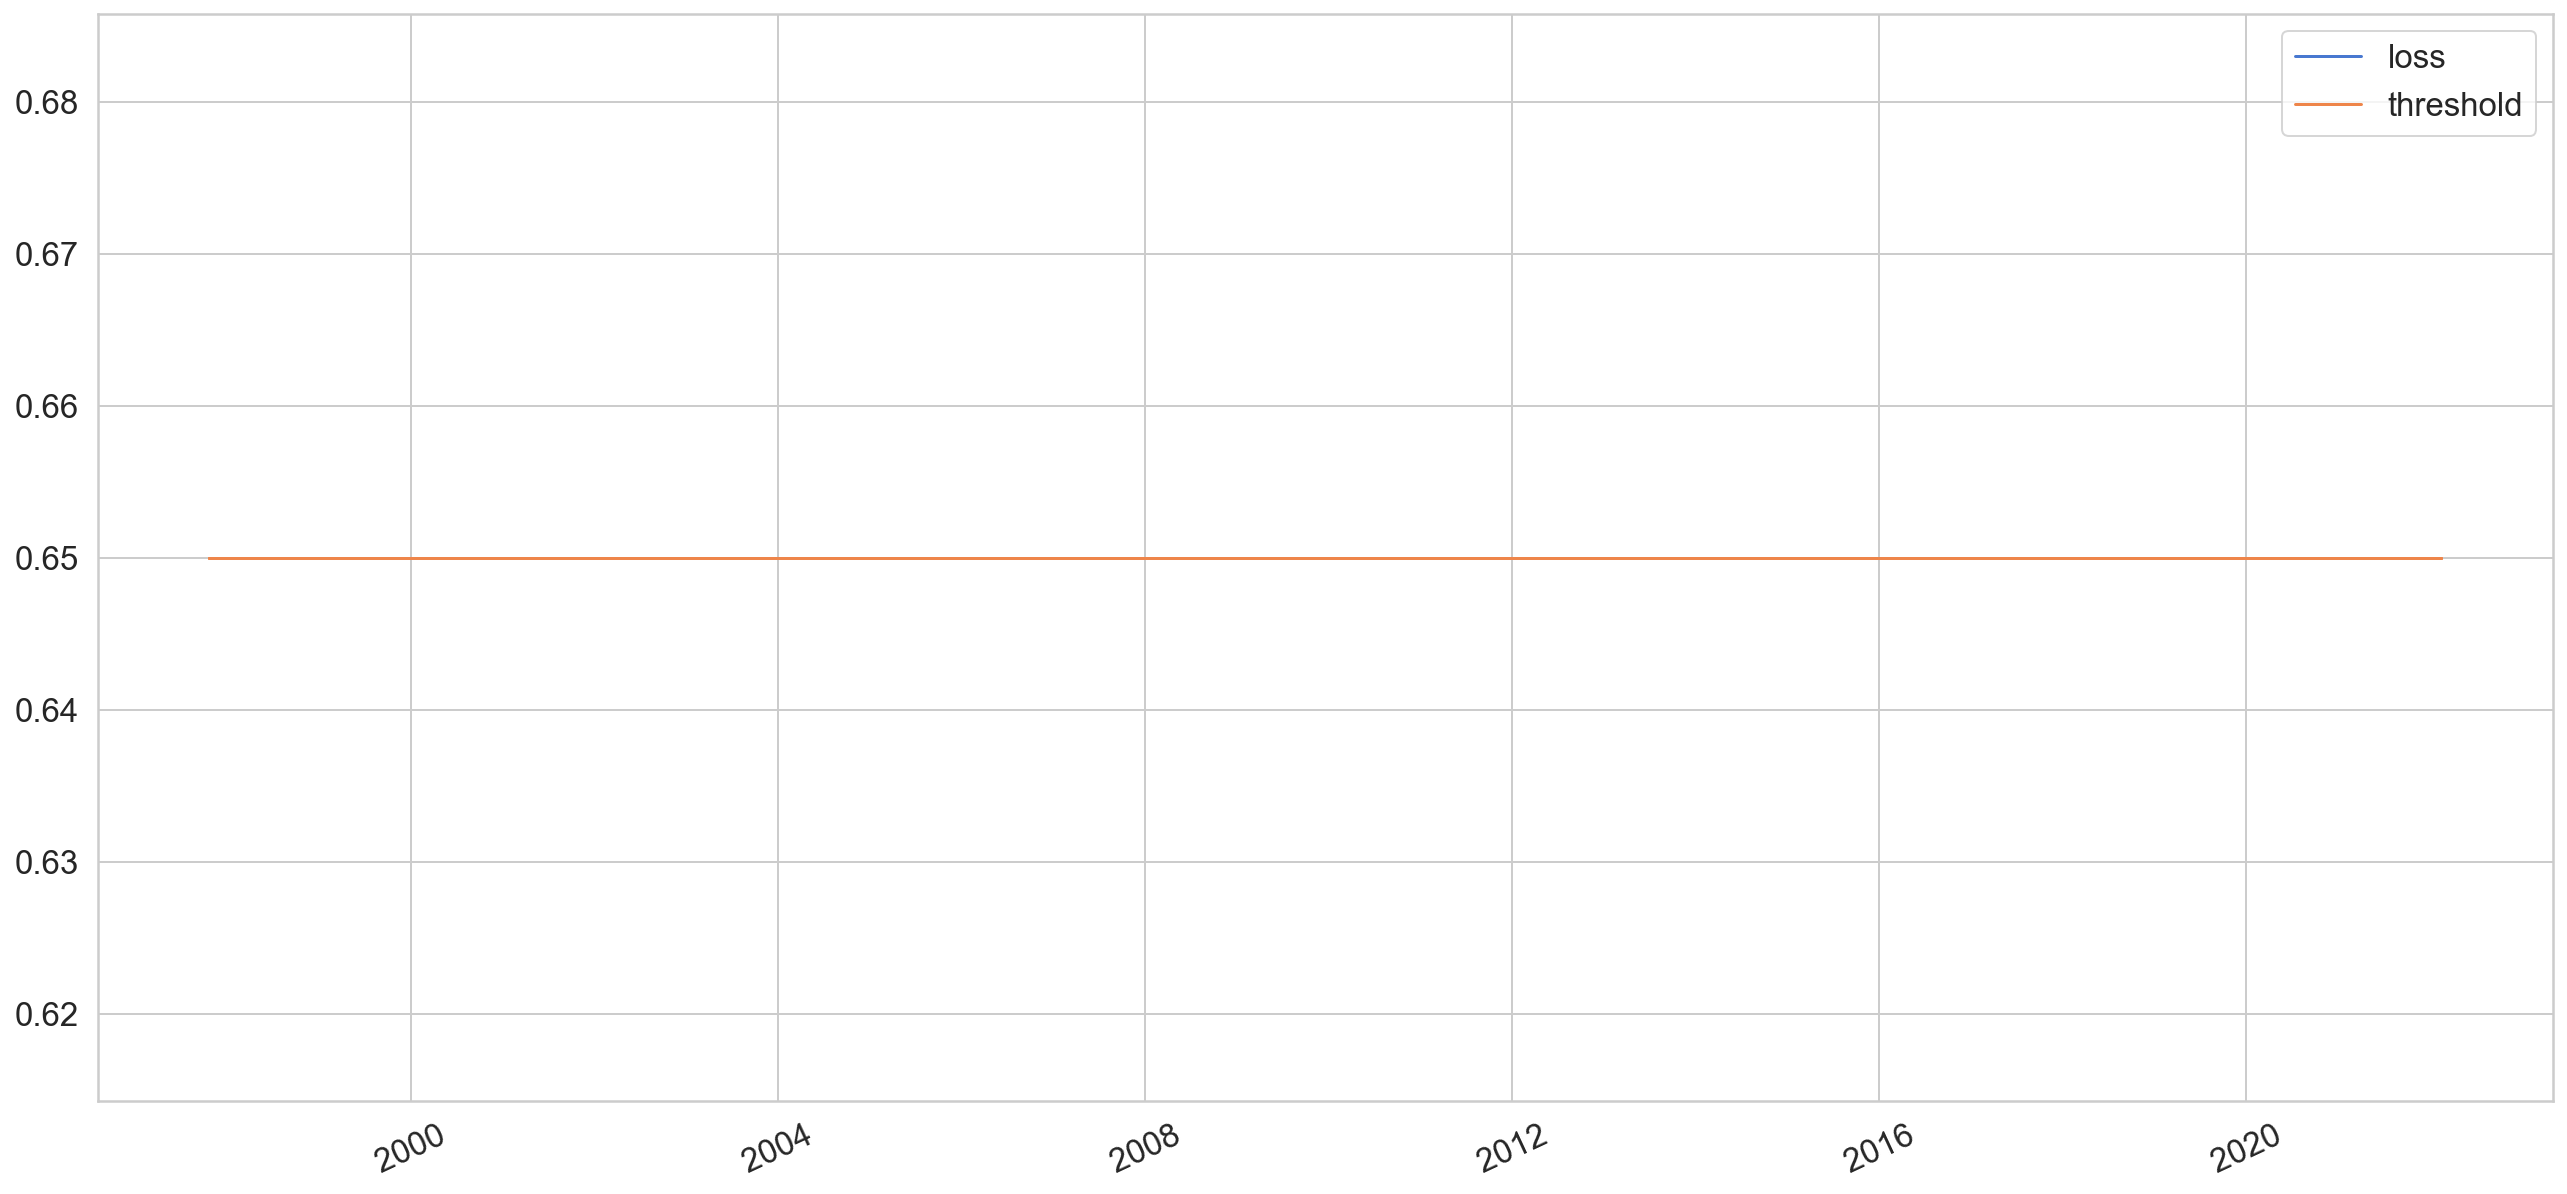

In [26]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [24]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].Close), 
  label='close price'
)

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.Close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend()

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.04981065  0.14461842  0.22869263 -1.20128661  0.16660756  2.22207018
 -0.03426356 -1.13163258 -0.04829224  1.2210423   0.06723231 -1.02429687
 -1.20458171  1.16502545  0.67845863  0.0243959  -0.40015111  1.62624278
  0.00566924 -0.76359179  1.09778566 -1.29681213         nan  0.30761211
 -0.97323899  0.15580874  0.94771141  1.75918899 -1.19094453  2.3968088
 -0.44253077 -0.2421164   1.86818857 -1.14354064  1.72000656 -1.19149916
  0.64658417  0.96206634  0.36702194 -1.39977612  0.29247419  0.56629444
 -1.00596171 -0.42530486  0.16957642         nan  0.53647534  0.13949632
  2.20706275  1.26900081  1.49489518 -0.7923669   0.46408083  0.51017972
  0.42026567  0.34604417  0.42160329  0.68795246 -0.93421969 -0.78434119
         nan  0.26467782  0.6458338   0.60211651  0.15375338  2.12510916
  0.2645147  -0.15357259  2.11930194 -0.41238542 -1.28904742  0.12752301
 -0.42882834 -1.29890012  0.37341641  0.228921    2.48075251  0.11183046
 -0.30338584  0.32111879 -1.297693    0.06925505 -0.26736802  0.20415875
  0.22533227 -1.25133311 -0.51841614  0.50117527 -1.37814585  0.16301883
  0.31188596  0.39690629  0.32111879 -1.18396282  1.79390181 -0.03348056
  0.61311108  2.24852892  1.91484208         nan  0.23538072  0.55203739
  1.50275777         nan  0.62479078 -1.33260158  0.4250289  -0.7917144
 -1.40581171  0.76370733  0.00439687  0.21048797  0.0446233   0.25410738
 -0.9481505   0.62616102  0.11783343 -0.8717105   0.13913745 -0.86286917
  0.13039399  0.31191859 -1.3074152   0.35818061 -1.247255   -0.75207522
  0.56352133  0.47027955 -1.18406069  0.30004315 -0.59469301  1.85960824
  1.46217247  1.56135197  1.85389889  0.04788578 -0.76590816  1.57541328
  0.19645929  0.27453052 -0.36041405 -0.86052018  0.55399488  1.47926788
 -0.03197982 -0.54696287 -0.82156613  0.31844356 -1.05274572 -1.26085956
 -1.1918254   0.20415875 -1.06449066  1.88707835 -0.0812107  -1.28493669
  1.27213279 -1.22624461 -0.4374413   0.38000662  0.38480247  0.54424005
 -1.06592616 -0.85774707 -1.13036021  0.14305243 -0.96354942  0.2890812
  0.12125904 -0.17950933 -1.27231088 -1.27123426 -0.15774857  0.04113244
 -1.1069682  -1.11897414 -1.27172363 -0.04959723 -1.2827182   0.60205126
 -1.15375222  1.77905751 -0.88613068 -1.04178378  0.87805739  2.26056748
 -1.20118873  2.06550358  0.60322576  0.6493899   0.24138369 -1.12210613
 -1.30056399  0.43403335  0.47465128 -1.32209638  1.79461956 -0.85484346
 -0.91200218  0.65301126  0.19499117  1.55795899 -0.79151865 -1.23247595
 -1.02569973 -1.16448579  0.12109592 -1.1316652   0.56678382 -0.77001888
  0.05659661 -0.17582273         nan -0.04790074  0.08243548  1.4117671
  0.10713249  0.04217644 -0.80512321 -0.92495424 -1.25926094  1.73344799
 -0.40328309  1.7174292  -1.14063703  0.20735599  0.52110904 -0.88782717
  1.6618691  -1.18879129  0.68005725  0.45709911 -0.9522286   0.05613987
 -0.31946988  0.19616567  0.47083417 -1.20487534 -0.4120918  -0.8060367
 -0.85327747  2.53605161  0.46453758  1.9771229   1.5204078  -1.2128358
  0.30627449 -1.24875574  0.24732141 -1.25906519  1.99872054  0.33221124
 -0.8866853  -0.23523255 -1.36998964 -1.28317495  0.9501909   1.83641198
 -1.30330447 -0.44615213  0.62514965 -1.0177719   0.26683106 -0.01468866
 -0.4065782  -1.0565302   0.71016997 -0.22143225  0.38333436 -1.33811517
 -1.05626921 -0.03302381  0.54410955  0.39821128 -0.39388714  0.04827728
 -1.05838982 -0.39088565].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.